### Unpack ETL files

In [4]:
import os
from pathlib import Path

from openai.types.beta.threads import image_file
from pandas.core.common import random_state

project_root = Path().resolve()
etl_dir = project_root / "data" / "ETL8G"
unpack_script = project_root / "data" / "unpack_etlcdb" / "unpack_etlcdb" / "unpack.py"

files = os.listdir(etl_dir)

for file in files:
    if file != "ETL8INFO":
        input_file = etl_dir / file
        cmd = f'python {unpack_script} {input_file}'
        print("Running:", cmd)
        # os.system(cmd)



Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_03
Running: python C:\Users\alicj\PycharmProjects\KanjiRecogniti

### Saving labels to list

In [5]:
import pandas as pd

path_to_labels = Path().resolve()/ "data" / "ETL8G"/ "ETL8G_01_unpack"/"meta.csv"

labels_df = pd.read_csv(path_to_labels)

labels = labels_df["char"]
labels = labels.tolist()


In [6]:
all_labels = labels.copy()
labels_copy = all_labels.copy()

for i in range(31):
    labels_copy_2 = labels_copy.copy()
    all_labels.extend(labels_copy_2)

all_labels.extend(labels_copy[:956])

In [7]:
# go through each folder
path_label_list = []
etl_dir = Path().resolve() / "data" / "ETL8G"
for folder in os.listdir(etl_dir):
    if "unpack" in folder:
        folder_path = os.path.join(etl_dir, folder)

        # go through each png in folder
        for fname in os.listdir(folder_path):
            if fname.endswith(".png"):
                fpath = os.path.join(folder_path, fname)
                # take filename without extension
                idx = int(os.path.splitext(fname)[0])
                # compute label
                label = idx % 956
                path_label_list.append((fpath, label))

print(path_label_list[956])


('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\00956.png', 0)


In [8]:
print(len(path_label_list))

153916


In [9]:
print(labels[1])
print(path_label_list[1912])

愛
('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\01912.png', 0)


### Saving images

In [10]:
image_paths = []
img_dir_path = Path().resolve()/ "data" / "ETL8G"

files = os.listdir(img_dir_path)
for file in files:
    if "unpack" in file:
        unpack_dir = img_dir_path / file
        img_files = os.listdir(unpack_dir)
        for img_file in img_files:
            if img_file != 'meta.csv':
                img_path = unpack_dir / img_file
                image_paths.append(img_path)

# in the last dir there are only 955 images



In [11]:
print(len(labels))

4780


### Dataset class

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as T

class ImageDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = Image.open(path).convert("L")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)
        return img, torch.tensor(label, dtype=torch.long)



In [13]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

a = ImageDataset(path_label_list, transform)
img, lab = a[0]
# print(img.size)
print(lab)
print(type(img), img.shape, lab)

tensor(0)
<class 'torch.Tensor'> torch.Size([1, 64, 64]) tensor(0)


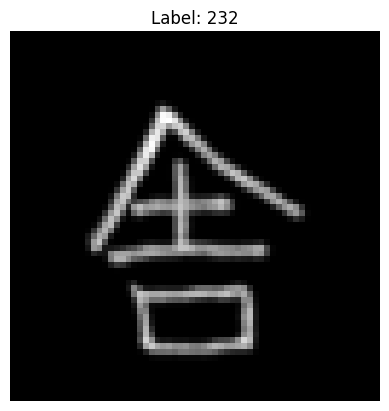

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img, label = a[5012]      # get transformed tensor (after __getitem__)
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


### Splitting the data into train, val, test sets

In [15]:
from sklearn.model_selection import train_test_split

# first split train vs temp (val+test)
train_data, temp_data = train_test_split(path_label_list[:20000], test_size=0.3, random_state=42, stratify=[d[1] for d in path_label_list[:20000]]) # used stratify to preserve the same class proportions

# then split temp into val and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=[d[1] for d in temp_data])


In [16]:
train_dataset = ImageDataset(train_data, transform)
val_dataset   = ImageDataset(val_data, transform)
test_dataset  = ImageDataset(test_data, transform)


### Data Loader

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=0)


TEST

In [18]:
imgs, labels = next(iter(train_loader))
print(imgs.shape)    # [32, 1, 64, 64]
print(labels.shape)  # [32]


torch.Size([32, 1, 64, 64])
torch.Size([32])


### Check data leakage

In [19]:
train_paths = [img[0] for img, _ in train_loader.dataset] if isinstance(train_loader.dataset[0], tuple) else [train_loader.dataset.data[i][0] for i in range(len(train_loader.dataset))]
val_paths   = [img[0] for img, _ in val_loader.dataset]   if isinstance(val_loader.dataset[0], tuple)   else [val_loader.dataset.data[i][0] for i in range(len(val_loader.dataset))]

# Turn them into sets
train_set = set(train_paths)
val_set = set(val_paths)

# Check for overlap
overlap = train_set.intersection(val_set)
print(f"Overlap count: {len(overlap)}")

if len(overlap) > 0:
    print("Example overlap paths:", list(overlap)[:5])
else:
    print("✅ No data leakage detected between train and validation sets!")


Overlap count: 0
✅ No data leakage detected between train and validation sets!


In [20]:
import time
t0 = time.time()
images, labels = next(iter(train_loader))
print(f"Loaded one batch in {time.time() - t0:.2f} seconds")
print("Batch shape:", images.shape, "Labels:", labels.shape)


Loaded one batch in 0.04 seconds
Batch shape: torch.Size([32, 1, 64, 64]) Labels: torch.Size([32])


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input: 1x64x64 → output: 8x64x64
        self.pool = nn.MaxPool2d(2, 2)                         # → 8x32x32
        self.dropout = nn.Dropout(0.3)
        self.fc   = nn.Linear(8 * 32 * 32, num_classes)        # flatten → fully connected

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))  # conv → relu → pool
        x = x.view(x.size(0), -1)            # flatten
        x = self.fc(x)                       # final layer
        return x


In [22]:
@torch.no_grad()
def evaluate(model, loader):
    """Compute accuracy of a model on a given DataLoader."""
    model.eval()                          # evaluation mode (no dropout, batchnorm updates)
    correct, total = 0, 0
    for images, labels in loader:
        outputs = model(images)            # forward pass
        preds = outputs.argmax(1)          # highest logit = predicted class
        correct += (preds == labels).sum().item()
        total += labels.numel()
    acc = correct / total
    return acc


In [23]:
@torch.no_grad()              # we don’t need gradients for validation
def calc_val_loss(model, val_loader, criterion):
    model.eval()              # turn off dropout/batchnorm updates
    total_loss = 0.0
    total_samples = 0

    for images, labels in val_loader:
        outputs = model(images)            # forward pass only
        loss = criterion(outputs, labels)  # compute loss for the batch
        total_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)

    avg_val_loss = total_loss / total_samples
    return avg_val_loss


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 64x64 -> 62x62 (no padding)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0, stride=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 62→31

        # 31x31 -> 15x15
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 15x15 -> 7x7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop  = nn.Dropout(0.2)
        self.fc    = nn.Linear(128 * 7 * 7, num_classes)


    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.flatten(1)      # [B, 128*7*7]
        x = self.drop(x)
        return self.fc(x)

In [26]:
# === setup ===
device = torch.device("cpu")   # change to "cuda" if you fix your GPU
num_classes = 956              # for example

model = CNN_1(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# assume you already have a DataLoader
# for example: train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

train_losses = []
val_losses = []

best_acc = 0.0  # start with 0
best_path = "best_model.pt"

# === training loop ===
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # move to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    val_loss = calc_val_loss(model, val_loader, criterion)
    # ---- store both ----
    train_losses.append(avg_loss)
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}: Train loss = {avg_loss:.4f}, Val acc = {val_acc*100:.2f}%")
    print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # --- check if this is the best so far ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best model saved (acc={best_acc:.4f})")

    # print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

print("✅ Training complete!")

Epoch 1: train_loss=4.7816, val_loss=1.1200, val_acc=72.47%
✅ New best model saved (acc=0.7247)
Epoch 2: train_loss=0.3565, val_loss=0.6427, val_acc=84.27%
✅ New best model saved (acc=0.8427)
Epoch 3: train_loss=0.0940, val_loss=1.7238, val_acc=71.13%
Epoch 4: train_loss=0.0544, val_loss=0.5230, val_acc=87.60%
✅ New best model saved (acc=0.8760)
Epoch 5: train_loss=0.0431, val_loss=1.3621, val_acc=73.73%
Epoch 6: train_loss=0.0497, val_loss=5.4484, val_acc=46.73%
Epoch 7: train_loss=0.0374, val_loss=0.4361, val_acc=90.77%
✅ New best model saved (acc=0.9077)
Epoch 8: train_loss=0.0495, val_loss=1.1052, val_acc=79.70%
Epoch 9: train_loss=0.0334, val_loss=0.3319, val_acc=92.70%
✅ New best model saved (acc=0.9270)
Epoch 10: train_loss=0.0234, val_loss=5.5388, val_acc=38.20%
Epoch 11: train_loss=0.0325, val_loss=0.3271, val_acc=92.37%
Epoch 12: train_loss=0.0203, val_loss=8.6759, val_acc=26.90%
Epoch 13: train_loss=0.0271, val_loss=0.6110, val_acc=87.13%
Epoch 14: train_loss=0.0305, val_los

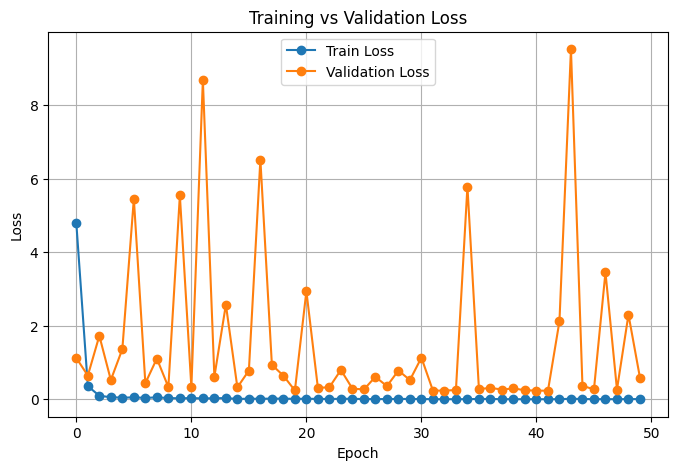

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# load weights
model = CNN_1(956)
model.load_state_dict(torch.load("best_model.pt", map_location="cpu"))
model.eval()

CNN_1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6272, out_features=956, bias=True)
)

In [31]:
tfm = T.Compose([
    T.Resize((64,64)),
    T.ToTensor(),
    T.Normalize([0.5],[0.5])
])


In [32]:
correct, total = 0, 0
test_loss = 0.0
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in test_loader:              # <- your existing DataLoader
        logits = model(x)
        test_loss += loss_fn(logits, y).item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

print(f"Test acc: {100*correct/total:.2f}% | Test loss: {test_loss/total:.4f}")

Test acc: 94.50% | Test loss: 0.2827


In [140]:
img_path = "C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_28_unpack\\00811.png"   # 👈 your own image
img = Image.open(img_path).convert("L")  # "L" = grayscale
x = tfm(img).unsqueeze(0)     # -> shape [1,1,64,64]


In [141]:
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(1).item()      # predicted class index
    probs = F.softmax(logits, dim=1)    # optional, to see confidence
    confidence = probs[0, pred].item()

print(f"Predicted class index: {pred}  |  confidence: {confidence:.2f}")


Predicted class index: 811  |  confidence: 0.93


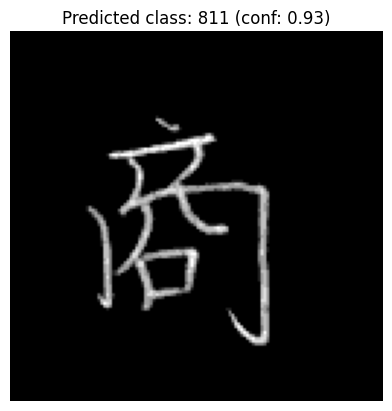

In [142]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.title(f"Predicted class: {pred} (conf: {confidence:.2f})")
plt.axis("off")
plt.show()


In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print(classification_report(all_labels, all_preds, digits=3))   # precision/recall/F1 per class

cm = confusion_matrix(all_labels, all_preds)                    # (956 x 956) matrix
# You can save cm to disk for plotting elsewhere:
np.save("confusion_matrix.npy", cm)


              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     0.750     0.857         4
           2      1.000     1.000     1.000         3
           3      1.000     1.000     1.000         3
           4      1.000     1.000     1.000         4
           5      1.000     1.000     1.000         3
           6      0.667     0.667     0.667         3
           7      1.000     1.000     1.000         3
           8      0.750     1.000     0.857         3
           9      1.000     1.000     1.000         3
          10      1.000     1.000     1.000         3
          11      1.000     1.000     1.000         3
          12      0.667     0.667     0.667         3
          13      1.000     0.667     0.800         3
          14      1.000     1.000     1.000         4
          15      1.000     1.000     1.000         3
          16      1.000     1.000     1.000         3
          17      1.000    

In [65]:
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
low_f1 = {label: stats for label, stats in report.items()
          if label.isdigit() and stats["f1-score"] < 0.6}

print(f"Liczba klas z F1 < 0.7: {len(low_f1)}\n")

for label, stats in low_f1.items():
    print(f"Klasa {label}: F1={stats['f1-score']:.3f}, "
          f"Precision={stats['precision']:.3f}, Recall={stats['recall']:.3f}")


Liczba klas z F1 < 0.7: 8

Klasa 123: F1=0.400, Precision=0.500, Recall=0.333
Klasa 201: F1=0.400, Precision=1.000, Recall=0.250
Klasa 281: F1=0.571, Precision=0.500, Recall=0.667
Klasa 289: F1=0.500, Precision=1.000, Recall=0.333
Klasa 399: F1=0.500, Precision=1.000, Recall=0.333
Klasa 865: F1=0.500, Precision=1.000, Recall=0.333
Klasa 871: F1=0.500, Precision=1.000, Recall=0.333
Klasa 903: F1=0.500, Precision=1.000, Recall=0.333


In [55]:
import numpy as np

cm = np.load("confusion_matrix.npy")
print("Shape:", cm.shape)


Shape: (956, 956)


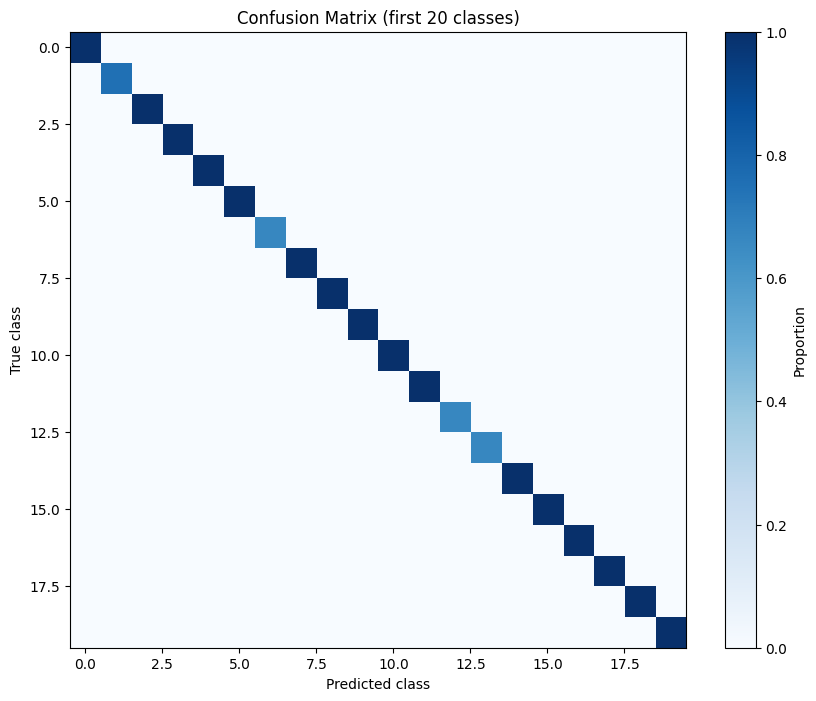

In [56]:
import matplotlib.pyplot as plt

# normalize per true class
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm[:20, :20], cmap="Blues")  # first 20 classes
plt.title("Confusion Matrix (first 20 classes)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar(label="Proportion")
plt.show()


In [57]:
# ignore correct predictions (diagonal)
np.fill_diagonal(cm, 0)
i, j = np.unravel_index(cm.argmax(), cm.shape)
print(f"Most confused: true class {i} → predicted as {j} ({cm[i,j]} times)")


Most confused: true class 399 → predicted as 495 (2 times)
